In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
import os 
from glob import glob

In [38]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

In [14]:
train_path = 'fruits-360-image/Train'
test_path = 'fruits-360-image/Test'

In [15]:
train_datagen = ImageDataGenerator(rescale=1/255,
                                  rotation_range=40,
                                  horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255)

In [16]:
train_flow = train_datagen.flow_from_directory(train_path,
                                              batch_size=32,
                                              class_mode='categorical',
                                              target_size=(100,100))
test_flow = test_datagen.flow_from_directory(test_path,
                                            batch_size=32,
                                            class_mode='categorical',
                                            target_size=(100,100))

Found 1472 images belonging to 3 classes.
Found 496 images belonging to 3 classes.


{'Banana': 0, 'Raspberry': 1, 'Strawberry': 2}
min: 0.06666667 max: 1.0


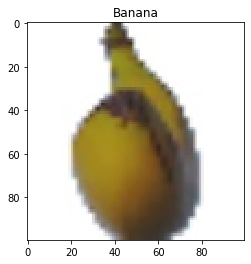

In [42]:
# get label mapping for confusion matrix plot later
print(test_flow.class_indices)
labels = [None] * len(test_flow.class_indices)
for k, v in test_flow.class_indices.items():
    labels[v] = k

# should be a strangely colored image (due to VGG weights being BGR)
for x, y in test_flow:
    print("min:", x[0].min(), "max:", x[0].max())
    plt.title(labels[np.argmax(y[0])])
    plt.imshow(x[0])
    plt.show()
    break

In [34]:
#Create Model
pre_trained_model = VGG16(input_shape=(100,100,3),
           include_top=False,
           weights='imagenet')

for layer in pre_trained_model.layers:
    layer.trainable=False

pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [48]:
x = Flatten()(pre_trained_model.output)
prediction = Dense(3, activation='softmax')(x)
model = Model(inputs=pre_trained_model.input, outputs=prediction)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [51]:
history = model.fit_generator(train_flow,
                             validation_data=test_flow,
                             epochs=1,
                             steps_per_epoch=1472 // 32,
                             validation_steps=496//32)

46/46 [==============================] - 332s 7s/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0166 - val_accuracy: 1.0000
